## Initial setup

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random

import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.transforms import ToTensor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [13]:
seed = 42
feature_size = 24
baseline_accuracy = 0.8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

random.seed(seed)
torch_seed = random.randint(0, 2 ** 32 - 1)
numpy_seed = random.randint(0, 2 ** 32 - 1)
torch.manual_seed(torch_seed)
torch.cuda.manual_seed(torch_seed)
np.random.seed(numpy_seed)

Using device: cuda


## Model

## Model

In [ ]:
class SoftMaxNeuralNetwork(nn.Module):
    def __init__(self, input_size: int, layer_size: int = 64):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.layers(x)
    
    def clasiffy(self, x):
        return torch.argmax(self.forward(x), dim=1)
    
class SigmoidNeuralNetwork(nn.Module):
    def __init__(self, input_size: int, layer_size: int = 64):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, 1),
        )

    def forward(self, x):
        return self.layers(x).view(-1)
    
    def clasiffy(self, x):
        return torch.round(nn.Sigmoid()(self.forward(x))).view(-1)

In [15]:
class SoftMaxNeuralNetwork(nn.Module):
    def __init__(self, input_size: int, layer_size: int = 64):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.layers(x)
    
    def clasiffy(self, x):
        return torch.argmax(self.forward(x), dim=1)
    
class SigmoidNeuralNetwork(nn.Module):
    def __init__(self, input_size: int, layer_size: int = 64):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, 1),
        )

    def forward(self, x):
        return self.layers(x).view(-1)
    
    def clasiffy(self, x):
        return torch.round(nn.Sigmoid()(self.forward(x))).view(-1)

## Helper Functions

#### Data processing functions

In [16]:
def load_data(feature_size: int):
    X = np.load('../Datasets/kryptonite-%s-X.npy'%(feature_size))
    y = np.load('../Datasets/kryptonite-%s-y.npy'%(feature_size))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, y_train, X_test, y_test


def convert_to_tensor_dataset(X, y):
    return torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32).to(device), torch.tensor(y, dtype=torch.float32).to(device))

#### Model optimization functions

In [17]:
def k_fold(train_dataset, num_folds, num_epochs, learning_rate, batch_size, weight_decay, model_type, layer_size, verbose=False):
    assert model_type == 'softmax' or model_type == 'sigmoid'

    kfold = KFold(n_splits=num_folds, shuffle=True)

    if verbose:
        print('Starting k-fold cross validation')
        print('---------------------------------------')

    fold_no = 0
    fold_losses = []
    fold_accuracies = []

    for train_index, validation_index in kfold.split(train_dataset):
        
        fold_no += 1

        if verbose:
            print('Training on fold:', fold_no)

        if model_type == 'softmax':
            net = SoftMaxNeuralNetwork(feature_size, layer_size).to(device)
            loss_fn = nn.CrossEntropyLoss()
        else:
            net = SigmoidNeuralNetwork(feature_size, layer_size).to(device)
            loss_fn = nn.BCEWithLogitsLoss()
            
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(validation_index)

        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, sampler=validation_subsampler)

        epoch_losses = []
        epoch_accuracies = []
        for epoch in range(num_epochs):
            batch_losses = []

            for inputs, labels in trainloader:
                net.zero_grad()
                outputs = net(inputs)
                if model_type == 'softmax':
                    labels = labels.long()
                loss = loss_fn(outputs, labels)

                batch_losses.append(loss.item())

                loss.backward()
                optimizer.step()

            epoch_loss = np.mean(batch_losses)
            epoch_losses.append(epoch_loss)

            with torch.no_grad():
                batch_accuracies = []
                for inputs, labels in validationloader:
                    outputs = net.clasiffy(inputs)
                    batch_accuracy = np.mean(outputs.cpu().numpy() == labels.cpu().numpy())
                    batch_accuracies.append(batch_accuracy.item())

            epoch_accuracy = np.mean(batch_accuracies)
            epoch_accuracies.append(epoch_accuracy)

            if epoch % 10 == 0 and verbose:
                print('Epoch:', epoch + 1, 'Loss:', epoch_losses[-1], 'Accuracy:', epoch_accuracies[-1])

        fold_losses.append(epoch_losses)
        fold_accuracies.append(epoch_accuracies)

    fold_accuracies = np.array(fold_accuracies)
    fold_losses = np.array(fold_losses)

    if verbose:
        print('---------------FINISHED----------------')
        print('Accuracies:', fold_accuracies[:, -1])
        print('Average accuracy:', np.mean(fold_accuracies, axis=0)[-1])

    return np.mean(fold_losses, axis=0), np.mean(fold_accuracies, axis=0)
                

In [18]:
def grid_search(train_dataset, num_folds, num_epochs, lrs: list, batch_sizes: list, regs: list, model_types: list, layer_sizes: list, verbose=False):
    result_map = dict()
    
    training_accuracies = []
    names = []

    for lr in lrs:
        for batch_size in batch_sizes:
            for reg in regs:
                for model_type in model_types:
                    for layer_size in layer_sizes:
                        train_losses, accuracies = k_fold(train_dataset, num_folds, num_epochs, lr, batch_size, reg, model_type, layer_size, verbose)
                        model_name = f"{model_type} model, {layer_size} neurons, Learning Rate {lr}, Batch Size {batch_size}, Regularization {reg}"
                        result_map[model_name] = accuracies[-1]

                        training_accuracies.append(accuracies)
                        names.append(model_name)

    if verbose:
        for i, name in enumerate(names):
            plt.plot(training_accuracies[i], label=name)

        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=1)
        plt.yticks(np.arange(0.4, 1.0, 0.05))
        plt.axhline(y=baseline_accuracy, color='r', linestyle='--')
        
        plt.show()
    
    sorted_models = [key for key, value in sorted(filter(lambda item: item[1] > baseline_accuracy, result_map.items()), key=lambda item: item[1], reverse=True)]
    
    print('Models which passed the baseline:', sorted_models)

    return result_map

## Model Training and Tunning

In [19]:
X_train, y_train, X_test, y_test = load_data(feature_size)

In [20]:
train_dataset = convert_to_tensor_dataset(X_train, y_train)

#### Hyperparameter Tunning

Starting k-fold cross validation
---------------------------------------
Training on fold: 1
Epoch: 1 Loss: 0.7034880254003737 Accuracy: 0.49192708333333335
Epoch: 11 Loss: 0.6886684894561768 Accuracy: 0.50625
Epoch: 21 Loss: 0.6768067412906222 Accuracy: 0.5140625
Epoch: 31 Loss: 0.6507621010144552 Accuracy: 0.5083333333333333
Epoch: 41 Loss: 0.6294648183716668 Accuracy: 0.4947916666666667
Training on fold: 2
Epoch: 1 Loss: 0.7022117508782281 Accuracy: 0.49713541666666666
Epoch: 11 Loss: 0.6886297067006429 Accuracy: 0.490625
Epoch: 21 Loss: 0.6740228666199578 Accuracy: 0.50703125
Epoch: 31 Loss: 0.6455806493759155 Accuracy: 0.49713541666666666
Epoch: 41 Loss: 0.6146630114979215 Accuracy: 0.49505208333333334
Training on fold: 3
Epoch: 1 Loss: 0.6995901200506423 Accuracy: 0.5041666666666667
Epoch: 11 Loss: 0.6829684972763062 Accuracy: 0.50859375
Epoch: 21 Loss: 0.658970832824707 Accuracy: 0.49973958333333335
Epoch: 31 Loss: 0.6257078912523057 Accuracy: 0.50625
Epoch: 41 Loss: 0.599444667

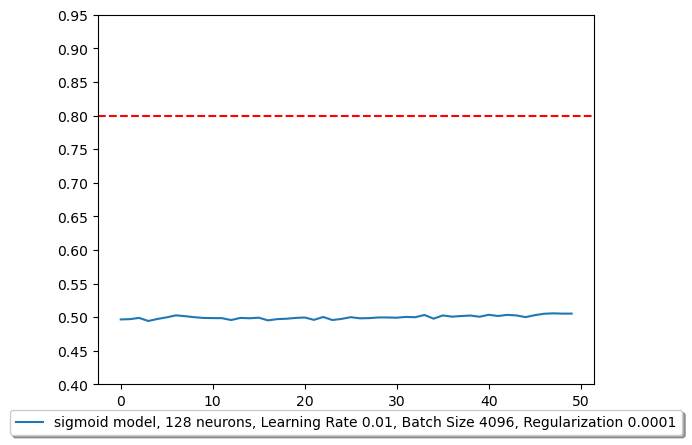

Models which passed the baseline: []


In [21]:
results =  grid_search(train_dataset=train_dataset, num_folds=10, num_epochs=50, 
            lrs=                [0.01], 
            batch_sizes=        [4096], 
            regs=               [1e-4], 
            model_types=        ['sigmoid'],
            layer_sizes=        [128],
            verbose=True)